prerequisites:  
tenpy: https://tenpy.github.io/INSTALL.html  
tensorflow: https://www.tensorflow.org/install  

In [1]:
from AD_tools import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,Conv2D,Conv1D,MaxPooling2D,MaxPooling1D,UpSampling2D,UpSampling1D,Flatten, Activation, BatchNormalization, GlobalAveragePooling2D,add

In [2]:
tf.__version__

'1.12.0'

In [3]:
import tenpy
tenpy.__version__

'0.4.1'

# Create data
Preferably run on a cluster / external session

In [4]:
Vs = np.linspace(0,5,100)

In [5]:
datas = []
for V in Vs:
    datas.append(hubbard_dmrg(L=8,U=5.,V=V,chi_max=64,bc="infinite"))
datas = np.array(datas)

Initial sweeps...
E = -6.0694700912326
0:00:31.232757
Initial sweeps...
E = -5.7045767476760
0:00:34.050718
Initial sweeps...
E = -5.3401870730464
0:00:34.298724
Initial sweeps...
E = -4.9763110539437
0:00:34.098505
Initial sweeps...
E = -4.6129590787029
0:00:34.811140
Initial sweeps...
E = -4.2501419539892
0:00:34.117167
Initial sweeps...
E = -3.8878709262272
0:00:34.563705
Initial sweeps...
E = -3.5261577021729
0:00:34.720659
Initial sweeps...
E = -3.1650144742022
0:00:34.614968
Initial sweeps...
E = -2.8044539413091
0:00:34.475068
Initial sweeps...
E = -2.4444893382511
0:00:34.555401
Initial sweeps...
E = -2.0851344637237
0:00:34.711723
Initial sweeps...
E = -1.7264037111817
0:00:34.431499
Initial sweeps...
E = -1.3683121028578
0:00:35.276108
Initial sweeps...
E = -1.0108753225437
0:00:35.175593
Initial sweeps...
E = -0.6541097568645
0:00:35.428429
Initial sweeps...
E = -0.2980325352883
0:00:35.578228
Initial sweeps...
E = 0.0573384251874
0:00:35.902029
Initial sweeps...
E = 0.41198

/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:418: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


E = 13.8414568496357
0:00:51.368895
Initial sweeps...


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:418: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


E = 14.1141439818711
0:03:33.339221
Initial sweeps...
E = 14.3803194854343
0:01:25.607169
Initial sweeps...
E = 14.6396359668914
0:01:03.999490
Initial sweeps...
E = 14.8916018687897
0:00:52.268760
Initial sweeps...
E = 15.1355689532778
0:00:39.697976
Initial sweeps...
E = 15.3708079693096
0:00:39.168365
Initial sweeps...
E = 15.5964847893283
0:00:39.074476
Initial sweeps...
E = 15.8116041591080
0:00:38.367786
Initial sweeps...
E = 16.0149094895726
0:00:37.940687
Initial sweeps...
E = 16.2046641902432
0:00:38.306033
Initial sweeps...


/home/kkottmann/TeNPy/tenpy/algorithms/dmrg.py:418: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


E = 16.3779765275217
0:01:14.997556
Initial sweeps...
E = 16.5276995780174
0:00:38.334427
Initial sweeps...
E = 16.6584050291836
0:00:30.053438
Initial sweeps...
E = 16.7762915749048
0:00:30.096485
Initial sweeps...
E = 16.8840396524024
0:00:29.250026
Initial sweeps...
E = 16.9833615341109
0:00:28.327332
Initial sweeps...
E = 17.0754849104977
0:00:27.916836
Initial sweeps...
E = 17.1613458581636
0:00:27.783631
Initial sweeps...
E = 17.2416866916748
0:00:27.429216
Initial sweeps...
E = 17.3171125327822
0:00:26.709410
Initial sweeps...
E = 17.3881269109902
0:00:26.267797
Initial sweeps...
E = 17.4551555719907
0:00:25.514407
Initial sweeps...
E = 17.5185631397365
0:00:23.726485
Initial sweeps...
E = 17.5786652018353
0:00:23.188639
Initial sweeps...
E = 17.6357373309060
0:00:22.038258
Initial sweeps...
E = 17.6900219795173
0:00:21.150542
Initial sweeps...
E = 17.7417338558647
0:00:19.984206
Initial sweeps...
E = 17.7910641857573
0:00:19.422693
Initial sweeps...
E = 17.8381841410737
0:00:18

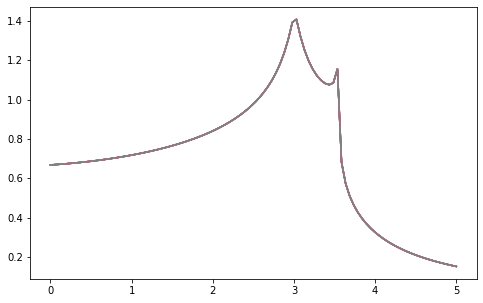

In [6]:
ent = np.array([psi.entanglement_entropy() for psi in datas[:,0]])
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(Vs,ent)

In [7]:
x_test = np.array([psi.entanglement_spectrum(by_charge=False)[int(psi.L/2)-1] for psi in datas[:,0]])
x_test = np.sqrt(np.exp(-1*x_test)) # Go from entanglement_spectrum to singular values l_v^2 = exp(-s_v)
x_test = x_test.reshape(*x_test.shape,1) # Need extra "color" channel (though trivial) for tensorflow later
x_test.shape

(100, 64, 1)

# Define CNN

In [8]:
def scc_cnn1D(loss,optimizer,activation0,activation,x_shape):
    in_dim = x_shape
    input_img = Input(shape=in_dim)
   
    x1 = Conv1D(64, 3, activation=activation0, padding='same')(input_img) # 100 100 64
    x2 = MaxPooling1D(2, padding='same')(x1) # 50 50 64
    x2 = Conv1D(64, 3, activation=activation0, padding='same')(x2) # 50 50 128
    x3 = MaxPooling1D(2, padding='same')(x2) # 25 25 128
    encoded = Conv1D(64, 3, activation=activation0, padding='same')(x3) # 25 25 128

    y=UpSampling1D(2)(encoded) # 50 50 128
    y=add([x2,y]) # 50 50 128
    y=Conv1D(64, 3, activation=activation0, padding='same')(y) # 50 50 128
    y=UpSampling1D(2)(y) # 100 100 128
    y=add([x1,y]) # 100 100 128
    decoded = Conv1D(x_shape[-1], 3, activation=activation, padding='same')(y) # 100 100 4

    cnn = Model(input_img, decoded)

    cnn.compile(loss=loss,optimizer=optimizer)#,metrics=['accuracy']) #adadelta
    return cnn

In [9]:
cnn = scc_cnn1D("mse","adam","relu","relu",(48,1,))
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 1)        0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 48, 64)       256         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 24, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 24, 64)       12352       max_pooling1d[0][0]              
__________________________________________________________________________________________________
max_poolin

# Training
pick data points from test set for training

In [10]:
Vs_train = Vs[np.where(Vs<2)]

In [11]:
x_train = x_test[np.where(Vs<2)]
x_train.shape

(40, 64, 1)

In [12]:
def train_loss2(y_true,y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.sum((y_true - y_pred)**2))

Train on 40 samples, validate on 40 samples
Epoch 1/40
40/40 [==============================] - 2s 48ms/step - loss: 3.5427 - val_loss: 3.1346
Epoch 2/40
40/40 [==============================] - 0s 1ms/step - loss: 3.0493 - val_loss: 2.6947
Epoch 3/40
40/40 [==============================] - 0s 1ms/step - loss: 2.6184 - val_loss: 2.2948
Epoch 4/40
40/40 [==============================] - 0s 1ms/step - loss: 2.2272 - val_loss: 1.9555
Epoch 5/40
40/40 [==============================] - 0s 1ms/step - loss: 1.8989 - val_loss: 1.6638
Epoch 6/40
40/40 [==============================] - 0s 1ms/step - loss: 1.6111 - val_loss: 1.3863
Epoch 7/40
40/40 [==============================] - 0s 1ms/step - loss: 1.3280 - val_loss: 1.0971
Epoch 8/40
40/40 [==============================] - 0s 1ms/step - loss: 1.0482 - val_loss: 0.8824
Epoch 9/40
40/40 [==============================] - 0s 1ms/step - loss: 0.8566 - val_loss: 0.7449
Epoch 10/40
40/40 [==============================] - 0s 1ms/step - loss: 

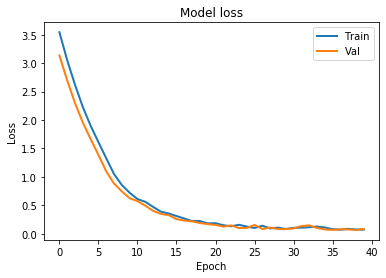

In [13]:
cnn0 = training(x_train, scc_cnn1D, name = "", provide_cnn = False,
             load_prev = False, num_epochs = 40,  verbose_val = 1, batch_size = 24, shuffle = True, early = False,
             loss = train_loss2, activation0 = 'relu', activation = 'tanh', optimizer = "adam")

In [14]:
xi = np.array([psi.correlation_length() for psi in datas[:,0]])

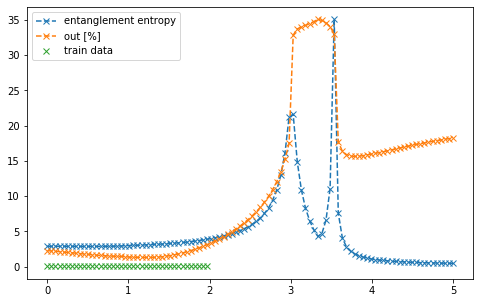

In [15]:
out = 100*eval_loss(x_test,cnn0.predict(x_test),norm=norm2)

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(Vs,np.max(out)*xi/xi.max(),"x--",label="entanglement entropy") # normalized to loss output
ax.plot(Vs,out,"x--",label="out [%]")
ax.plot(Vs_train,out[np.where(Vs<2)]/np.max(out),"x",label="train data")
ax.legend()